In [1]:
# import data from drive

from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/Malaria_Dataset.zip"
!unzip -q "/content/gdrive/My Drive/Malaria_parasite_model.h5.zip"


Mounted at /content/gdrive


In [13]:
'''

project : Malaria_Dataset
Author : @kanishksh4rma

'''

'\n\nproject : Malaria_Dataset\nAuthor : @kanishksh4rma\n\n'

In [14]:
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import AveragePooling2D, Dropout,Flatten,Dense,Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [16]:
dataset = "/content/Dataset/Train"   # path to the dataset
args={}
args["dataset"]=dataset

In [ ]:
import numpy as np
import cv2
img_paths = list(paths.list_images(args["dataset"]))  #image paths
data = []
labels = []
for path in img_paths:
    label = path.split(os.path.sep)[-2]   #split the image paths
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Convert images into RGB Channel
                                                   # Though it isnt necessary for X-ray images
    print(label)
    image = cv2.resize(image, (224, 224))  #Resizing the images
    data.append(image)
    labels.append(label)
data = np.array(data) / 255.0
labels = np.array(labels)

In [24]:
LB = LabelBinarizer()  
#Initialize label binarizer
labels = LB.fit_transform(labels)
labels = to_categorical(labels)

In [25]:
# test train split
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

In [26]:
#rotate images to create more data
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

In [27]:
bModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))  #base_Model
hModel = bModel.output #head_Model
hModel = AveragePooling2D(pool_size=(4, 4))(hModel)
hModel = Flatten(name="flatten")(hModel)
hModel = Dense(64, activation="relu")(hModel)
hModel = Dropout(0.5)(hModel)
hModel = Dense(2, activation="sigmoid")(hModel)
model = Model(inputs=bModel.input, outputs=hModel)

for layer in bModel.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [28]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((332, 224, 224, 3), (84, 224, 224, 3), (332, 2), (84, 2))

In [29]:
INIT_LR = 1e-3
EPOCHS = 20
BS = 8

In [34]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [35]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

R = model.fit_generator(
    trainAug.flow(X_train, Y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, Y_test),
    epochs=EPOCHS,
    callbacks=[learn_control, checkpoint])

Epoch 1/20
41/41 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.8384WARNING:tensorflow:Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr

Epoch 00001: val_accuracy improved from -inf to 0.86905, saving model to weights.best.hdf5
41/41 [==============================] - 7s 165ms/step - loss: 0.3560 - accuracy: 0.8384 - val_loss: 0.3424 - val_accuracy: 0.8690
Epoch 2/20
41/41 [==============================] - ETA: 0s - loss: 0.3841 - accuracy: 0.8457WARNING:tensorflow:Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr

Epoch 00002: val_accuracy did not improve from 0.86905
41/41 [==============================] - 4s 98ms/step - loss: 0.3841 - accuracy: 0.8457 - val_loss: 0.3467 - val_accuracy: 0.8571
Epoch 3/20
41/41 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.

0 : Affected by Malaria
1 : Healthy Person


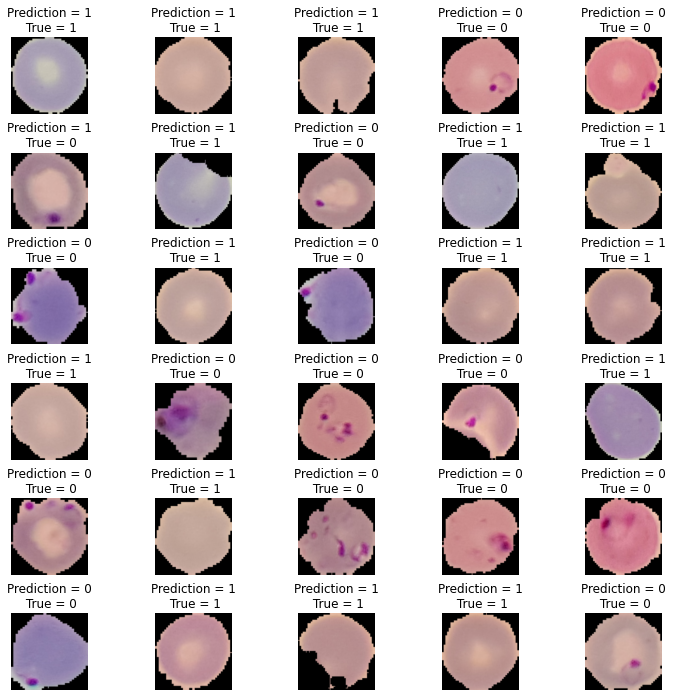

In [36]:

# Let's test on some random test data

L = 6
W = 5
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
y_pred = model.predict(X_test, batch_size=BS)
for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred.argmax(axis=1)[i], Y_test.argmax(axis=1)[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5, hspace=0.5)  
print('0 : Affected by Malaria\n1 : Healthy Person') 

Wow! All every prediction are correct.

In [37]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test, batch_size=BS)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(Y_test.argmax(axis=1), y_pred,target_names=LB.classes_))

              precision    recall  f1-score   support

    Parasite       1.00      0.80      0.89        44
  Uninfected       0.82      1.00      0.90        40

    accuracy                           0.89        84
   macro avg       0.91      0.90      0.89        84
weighted avg       0.91      0.89      0.89        84



In [38]:
from sklearn.metrics import accuracy_score
print('Accuracy score : ',accuracy_score(Y_test.argmax(axis=1),y_pred)*100,'%')

Accuracy score :  89.28571428571429 %


In [39]:
from sklearn.metrics import confusion_matrix

# check for Sensitivity & Specificity

cm = confusion_matrix(Y_test.argmax(axis=1), y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[35  9]
 [ 0 40]]
acc: 0.8929
sensitivity: 0.7955
specificity: 1.0000


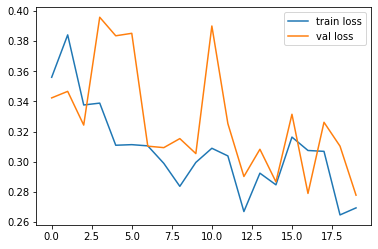

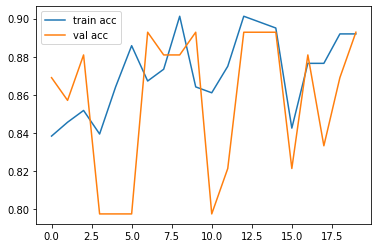

<Figure size 432x288 with 0 Axes>

In [40]:
# plot the loss
plt.plot(R.history['loss'], label='train loss')
plt.plot(R.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(R.history['accuracy'], label='train acc')
plt.plot(R.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('LossVal_acc')

In [41]:
model.save('Malaria_parasite_model3.h5')

In [ ]:
from flask import jsonify
from keras.preprocessing import image
from keras.models import load_model
print('making model ')
from google.colab import files
image1 = files.upload()
image_list = list(image1.keys())
image1 = image_list[0]
print('Image : ',image1)
print('=========================')
print('File uploaded successfully!!!')
print('=========================')

In [49]:
import numpy as np
from flask import jsonify
from keras.preprocessing import image
from keras.models import load_model
print('fetching results...')
new_model = load_model('/content/Malaria_parasite_model3.h5')
test_image = image.load_img(image1,target_size=(224,224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

result = new_model.predict(test_image)
y_pred = np.argmax(result, axis=1)
print('Model prediction: ',result)

'''if result[0][0]==1.0 and result[0][1]<=0.3 or result[0][1]==1.0 and result[0][0]<=0.3:
  prediction = "Please upload x ray only"'''

#if result[0][0]<result[0][1] and result[0][0]>4.226988e-15:
if y_pred == 0:
  prediction = 'Patient is affected with Malaria'
  #return 1
else:
  prediction = 'Patient is Healthy'
  #return 0


print('YPred',y_pred)
print('===================================')
print(prediction)
print('===================================')


fetching results...
Model prediction:  [[5.0179767e-09 1.0000000e+00]]
YPred [1]
Patient is Healthy
